In [5]:
%%capture
!pip install tensorflow pandas tqdm pyyaml h5py

In [6]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
from tensorboard.plugins.hparams import api as hp
from sklearn.model_selection import train_test_split

In [7]:
gpus = tf.config.experimental.list_physical_devices('GPU')
try:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except RuntimeError as e:
    print(e)

In [8]:
data_single_train = dict(np.load("./data/data_single_train.npz"))
data_single_train["sequence_feat"].shape

(8550, 43, 24)

In [9]:
L = tf.keras.layers

In [10]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

In [11]:
def R2(y_true, y_pred):
    residual = tf.reduce_sum(tf.square(tf.subtract(y_true, y_pred)))
    total = tf.reduce_sum(tf.square(tf.subtract(y_true, tf.reduce_mean(y_true))))
    r2 = tf.subtract(1.0, tf.divide(residual, total))
    return r2

In [12]:
hparams = {
    "sequence_units": [32],
    "dense": [16],
}
hparams = {
    key: hp.HParam(key, hp.Discrete(value))
    for key, value in hparams.items()
}
metrics = [
    hp.Metric("mae", display_name="MAE"),
    hp.Metric("mse", display_name="MSE"),
    hp.Metric("r2", display_name="R2"),
]
hp.hparams_config(
    hparams=list(hparams.values()),
    metrics=metrics
)

<tf.Tensor: shape=(), dtype=bool, numpy=False>

In [13]:
from itertools import product
from random import shuffle

def hparams_combinations(hparams):
    hparams_values = product(*[
        h.domain.values
        for h in hparams.values()
    ])
    hparams = [
        dict(zip(hparams.keys(), values))
        for values in hparams_values
    ]
    shuffle(hparams)
    return hparams

In [14]:
def build_model(hparams):
    model = tf.keras.Sequential([
        L.Input(shape=data_single_train["sequence_feat"].shape[1:], name="sequence_feat"),
        L.LSTM(hparams["sequence_units"]),
        L.Dense(1)
    ])
    model.compile(optimizer="adam", loss=rmse, metrics=["mae", "mse", R2])
    return model

In [11]:
model = build_model({"sequence_units": 32, "dense": 16})

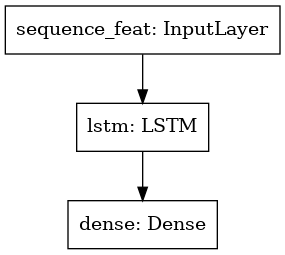

In [12]:
from IPython.display import Image
tf.keras.utils.plot_model(model, to_file="model.png")
Image("model.png")

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                7296      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 7,329
Trainable params: 7,329
Non-trainable params: 0
_________________________________________________________________


In [17]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=30)

In [ ]:
index = np.arange(len(data_single_train["score"]))
train_index, test_index = train_test_split(index, test_size=0.30, random_state=42)
train_index, val_index = train_test_split(train_index, test_size=0.10, random_state=42)
X_train = [data_single_train[i.name][train_index] for i in model.inputs]
X_test = [data_single_train[i.name][test_index] for i in model.inputs]
X_val = [data_single_train[i.name][val_index] for i in model.inputs]
y_train, y_test, y_val = data_single_train["score"][train_index], data_single_train["score"][test_index],  data_single_train["score"][val_index]

In [ ]:
path = "./board"
for i, h in enumerate(tqdm(hparams_combinations(hparams))):
    logs = os.path.join(path, f"run-{i}")
    os.makedirs(logs)
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir=logs)
    with tf.summary.create_file_writer(logs).as_default():
        hp.hparams(h)
        model = build_model(h)
        model.fit(
            X_train,
            y_train,
            epochs=int(1e3),
            batch_size=32,
            shuffle=True,
            validation_data=(X_val, y_val),
            callbacks=[early_stop, tensorboard],
            verbose=0
        )
        loss, mae, mse, r2 = model.evaluate(X_test, y_test, verbose=0)
        tf.summary.scalar("loss", loss, step=i)
        tf.summary.scalar("mae", mae, step=i)
        tf.summary.scalar("mse", mse, step=i)
        tf.summary.scalar("r2", r2, step=i)

In [15]:
parameters = {"sequence_units": 32, "dense": 16}

In [18]:
model = build_model(parameters)
X_train = [data_single_train[i.name] for i in model.inputs]
y_train = data_single_train["score"]
history = model.fit(
    X_train,
    y_train,
    epochs=int(1e3),
    batch_size=32,
    shuffle=True,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)
history = pd.DataFrame(history.history).to_csv("model_single_train_history.csv")

Epoch 1/1000
241/241 [==============================] - 5s 7ms/step - loss: 0.4509 - mae: 0.3718 - mse: 0.2405 - R2: -0.8105 - val_loss: 0.2861 - val_mae: 0.2220 - val_mse: 0.0840 - val_R2: 0.4600
Epoch 2/1000
241/241 [==============================] - 1s 6ms/step - loss: 0.2688 - mae: 0.2029 - mse: 0.0747 - R2: 0.5190 - val_loss: 0.2599 - val_mae: 0.1990 - val_mse: 0.0692 - val_R2: 0.5470
Epoch 3/1000
241/241 [==============================] - 1s 6ms/step - loss: 0.2502 - mae: 0.1854 - mse: 0.0647 - R2: 0.5812 - val_loss: 0.2569 - val_mae: 0.1963 - val_mse: 0.0677 - val_R2: 0.5561
Epoch 4/1000
241/241 [==============================] - 1s 5ms/step - loss: 0.2457 - mae: 0.1833 - mse: 0.0627 - R2: 0.5923 - val_loss: 0.2487 - val_mae: 0.1849 - val_mse: 0.0638 - val_R2: 0.5827
Epoch 5/1000
241/241 [==============================] - 1s 6ms/step - loss: 0.2425 - mae: 0.1781 - mse: 0.0608 - R2: 0.5943 - val_loss: 0.2518 - val_mae: 0.1828 - val_mse: 0.0656 - val_R2: 0.5734
Epoch 6/1000
241/24

In [17]:
model.save("model_single.h5")

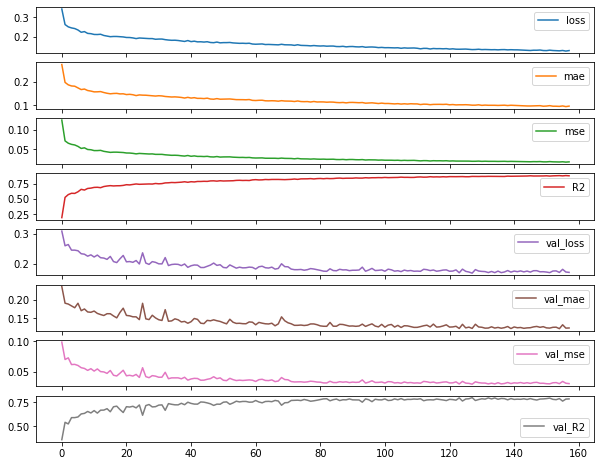

In [18]:
_ = pd.DataFrame(history.history).plot(subplots=True, figsize=(10, 8))

In [19]:
data_single_test = dict(np.load("./data/data_single_test.npz"))
X_test = [data_single_test[i.name] for i in model.inputs]
y_test = data_single_test["score"]
evaluate = pd.DataFrame([y_test, model.predict(X_test).squeeze()], index=["target", "predicted"]).T
evaluate.corr()

,target,predicted
target,1.000000,0.910432
predicted,0.910432,1.000000


In [20]:
evaluate.to_csv("evaluate_single.csv")

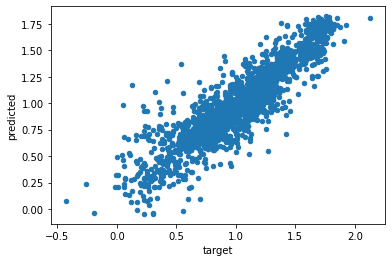

In [21]:
_ = evaluate.plot.scatter("target", "predicted")

In [22]:
data_multi_train = dict(np.load("./data/data_multi_train.npz"))
data_multi_train["sequence_feat"].shape

(29156, 43, 24)

In [23]:
model = build_model(parameters)
X_train = [data_multi_train[i.name] for i in model.inputs]
y_train = data_multi_train["score"]
history = model.fit(
    X_train,
    y_train,
    epochs=int(1e3),
    batch_size=64,
    shuffle=True,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/1000
410/410 [==============================] - 4s 6ms/step - loss: 0.4777 - mae: 0.3650 - mse: 0.2333 - R2: -0.0361 - val_loss: 0.3964 - val_mae: 0.2984 - val_mse: 0.1595 - val_R2: 0.0570
Epoch 2/1000
410/410 [==============================] - 2s 5ms/step - loss: 0.4448 - mae: 0.3413 - mse: 0.2003 - R2: 0.1089 - val_loss: 0.3931 - val_mae: 0.3005 - val_mse: 0.1567 - val_R2: 0.0686
Epoch 3/1000
410/410 [==============================] - 2s 5ms/step - loss: 0.4378 - mae: 0.3380 - mse: 0.1941 - R2: 0.1261 - val_loss: 0.3669 - val_mae: 0.2810 - val_mse: 0.1363 - val_R2: 0.1869
Epoch 4/1000
410/410 [==============================] - 2s 5ms/step - loss: 0.4283 - mae: 0.3312 - mse: 0.1853 - R2: 0.1728 - val_loss: 0.3613 - val_mae: 0.2825 - val_mse: 0.1320 - val_R2: 0.2081
Epoch 5/1000
410/410 [==============================] - 2s 5ms/step - loss: 0.4173 - mae: 0.3243 - mse: 0.1759 - R2: 0.2104 - val_loss: 0.3511 - val_mae: 0.2726 - val_mse: 0.1246 - val_R2: 0.2521
Epoch 6/1000
410/41

In [24]:
model.save("model_multi.h5")

In [25]:
data_multi_test = dict(np.load("./data/data_multi_test.npz"))
X_test = [data_multi_test[i.name] for i in model.inputs]
y_test = data_multi_test["score"]
evaluate = pd.DataFrame([y_test, model.predict(X_test).squeeze()], index=["target", "predicted"]).T
evaluate.corr()

,target,predicted
target,1.000000,0.550283
predicted,0.550283,1.000000


In [26]:
evaluate.to_csv("evaluate_multi.csv")

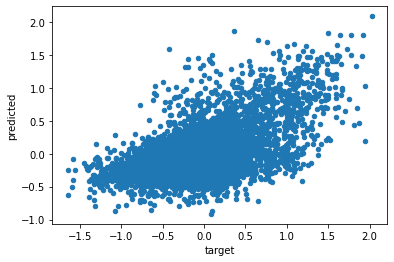

In [27]:
_ = evaluate.plot.scatter("target", "predicted")